In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rulevetting.api.viz as viz
from rulevetting.projects.tbi_pecarn.dataset import Dataset
import os
import pickle as pkl
from os.path import join as oj

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imodels
from rulevetting.api import validation
%matplotlib inline
%reload_ext autoreload
%autoreload 2

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)
outcome_def = 'outcome'  # output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Load Dataset and change the variables into factors

#1. Load data
path_to_data_folder = "../../../../data/tbi_pecarn/raw/"
dset = Dataset()
df_pub = dset.load_data(data_path = path_to_data_folder)

In [4]:
#2. Remove columns with NaNs
preprocess_df = dset.remove_data(data = df_pub, frac_missing_allowed = 0.072)
preprocess_df.head()

,PatNum,EmplType,Certification,InjuryMech,High_impact_InjSev,Amnesia_verb,LOCSeparate,LocLen,Seiz,SeizOccur,...,Finding20,Finding21,Finding22,Finding23,DeathTBI,HospHead,HospHeadPosCT,Intub24Head,Neurosurgery,PosIntFinal
0,1,3.0,3,11.0,2.0,0.0,0.0,92.0,0.0,92.0,...,92,92,92,92,0.0,0.0,0,0.0,0.0,0.0
1,2,5.0,3,8.0,2.0,0.0,0.0,92.0,0.0,92.0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
3,4,5.0,3,6.0,1.0,91.0,0.0,92.0,0.0,92.0,...,92,92,92,92,0.0,0.0,0,0.0,0.0,0.0
5,6,3.0,3,NaN,NaN,91.0,0.0,92.0,0.0,92.0,...,92,92,92,92,0.0,0.0,0,0.0,0.0,0.0
6,7,3.0,3,7.0,1.0,0.0,0.0,92.0,0.0,92.0,...,92,92,92,92,0.0,0.0,0,0.0,0.0,0.0


In [5]:
def nan_mean(df):
    per_nan = df.isna().mean()
    nan_mean = per_nan[per_nan != 0]
    return nan_mean

In [6]:
## We focus on the children with GCSscore greater or equal to 14,
## because they are at low risk of being identified as at very low risk of ciTBI
remove_revord = ["PosIntFinal"]
remove_var = ["Dizzy", "Ethnicity", "Race", "Observed", "GCSGroup"]
impute_missing = ["LocLen", "LOCSeparate", "Drugs", "HAStart", "HASeverity", "VomitLast", "CTSed", "Seiz", 
                  "HemaSize", "SFxBas", "VomitStart", "NeuroD", "Paralyzed", "Vomit", "Hema", "InjuryMech" ,
                  "HemaLoc", "OSI", "FontBulg", "Clav", "SFxPalp", "SeizLen" , 
                  "SeizOccur", "SFxPalpDepress", "CTForm1", "EDDisposition", "EmplType"] ##impute 92
impute_knn = ["Amnesia_verb", "GCSMotor", "GCSVerbal", "GCSEye", "Sedated", "AMS", 
              "High_impact_InjSev", "Intubated", "VomitNbr", "Gender", "Intub24Head", "HospHead"]
impute_91 = ["HA_verb"] ## impute "91" if patients are under 2. otherwise imput 92.

In [51]:
missing_per = nan_mean(df_pub[df_pub.GCSTotal >= 14]).sort_values(ascending = False)
missing_per
## Drop "Dizzy", "Ethnicity", "Race" 
## since they are no very important according to the responses of the doctor
## "ActNorm" is considered as an important index for patients under 2 years old.
## "LocLen" can be included by imputing the missings with 92
## "Observed" depends on the doctors assesssment which likes an outcome of the symptoms, and we deleted it
## since we can get the information from other covariates
## "Amnesia_verb" can probably be imputed if the patient is under 2 years old.
## "LOCSeparate" if missing then mark as "unknown" (it is related to "LocLen")
## "Drugs", "HAStart", "HASeverity", "VomitLast", "CTSed", "Seiz", "HemaSize" impute missing
## "SFxBas", "VomitStart", "NeuroD", "Paralyzed", "Vomit", "Hema", "InjuryMech" 
## "HemaLoc", "OSI", "FontBulg", "Clav", "SFxPalp", "SeizLen" 
## "SeizOccur", "SFxPalpDepress", "CTForm1", "EDDisposition", "EmplType"impute missing
## "GCSMotor", "GCSVerbal", "GCSEye", "Sedated", "AMS", "High_impact_InjSev", "Intubated"impute KNN
## "VomitNbr", "Gender", "Intub24Head", "HospHead"  impute KNN
## "HA_verb" impute "91" if patients are under 2. otherwise imput 92.

Ethnicity             0.366321
Dizzy                 0.356446
Race                  0.072779
ActNorm               0.070940
Observed              0.054183
LocLen                0.053853
Amnesia_verb          0.048833
Drugs                 0.041881
LOCSeparate           0.040514
HAStart               0.030945
GCSMotor              0.029861
GCSVerbal             0.029649
GCSEye                0.029625
HASeverity            0.023804
VomitLast             0.021447
CTSed                 0.020952
Seiz                  0.016969
HemaSize              0.016710
HA_verb               0.010511
SFxBas                0.009922
VomitStart            0.008720
NeuroD                0.008485
Sedated               0.007565
Paralyzed             0.007542
AMS                   0.007448
High_impact_InjSev    0.007377
Intubated             0.007306
Vomit                 0.007094
Hema                  0.006882
InjuryMech            0.006670
VomitNbr              0.005963
HemaLoc               0.004737
OSI     

In [7]:
df1 = df_pub.drop(remove_var, 1)
df2 = df1.dropna(subset=["PosIntFinal"])
df3 = df2[df2.GCSTotal >= 14]

C:\Users\18723\AppData\Local\Temp/ipykernel_10944/3197146204.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1 = df_pub.drop(remove_var, 1)


In [8]:
## Fill missings with 92 and 91
## Impute some missings by KNN
df4 = df3.copy()
df4[impute_missing] = df3[impute_missing].fillna(92)
df4[impute_91] = df3[impute_91].fillna(91)
df_knn = dset.impute_data(data = df4, imputation = "KNN")

In [25]:
###### Drop PatNum column
## Change the numeric values into characteristic values
df_knn = df_knn.drop("PatNum", 1)

demographics = ['AgeInMonth', 'AgeinYears', 'AgeTwoPlus', 'Gender', 'Ethnicity', 'Race']
hospitalStats = ['PatNum', 'EmplType', 'Certification']
symptoms = ['InjuryMech', 'High_impact_InjSev', 'Amnesia_verb', 'LocLen', 'Seiz', 'SeizOccur', 'SeizLen', 'ActNorm',
                'HA_verb', 'HASeverity', 'HAStart', 'Vomit', 'VomitNbr', 'VomitStart', 'VomitLast', 'Dizzy', 'GCSEye',
                'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup', 'AMS', 'AMSAgitated', 'AMSSleep', 'AMSSlow', 
                'AMSRepeat', 'AMSOth', 'SFxPalp', 'SFxPalpDepress', 'FontBulg', 'SFxBas', 'SFxBasHem', 'SFxBasOto',
                'SFxBasPer', 'SFxBasRet', 'SFxBasRhi', 'Hema', 'HemaLoc', 'HemaSize', 'Clav', 'ClavFace', 'ClavNeck',
                'ClavFro', 'ClavOcc', 'ClavTem', 'NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 
                'NeuroDReflex', 'NeuroDOth', 'OSI', 'OSIExtremity', 'OSICut', 'OSICspine', 'OSIFlank', 'OSIAbdomen',
                'OSIPelvis', 'OSIOth', 'Drugs', 'LOCSeparate']
hospitalActions = ['Intubated', 'Paralyzed', 'Sedated', 'CTForm1', 'IndAge', 'IndAmnesia', 'IndAMS', 'IndClinSFx',
                       'IndHA', 'IndHema', 'IndLOC', 'IndMech', 'IndNeuroD', 'IndRqstMD', 'IndRqstParent',
                       'IndRqstTrauma', 'IndSeiz', 'IndVomit', 'IndXraySFx', 'IndOth', 'CTSed', 'CTSedAgitate',
                       'CTSedAge', 'CTSedRqst', 'CTSedOth', 'Observed', 'EDDisposition', 'CTDone', 'EDCT']
outcomes = ['PosCT', 'Finding1', 'Finding2', 'Finding3', 'Finding4', 'Finding5', 'Finding6', 'Finding7',
 'Finding8', 'Finding9', 'Finding10', 'Finding11', 'Finding12', 'Finding13', 'Finding14', 'Finding20', 'Finding21',
 'Finding22', 'Finding23', 'DeathTBI', 'HospHead', 'HospHeadPosCT', 'Intub24Head', 'Neurosurgery', 'PosIntFinal']

In [11]:
## First split the data into train, test and validation
# Create random training and test splits
n = df_knn.shape[0]
train_size = round(0.6 * n)
tune_size = round(0.2 * n)
test_size = n - train_size - tune_size
train_indices = np.random.choice(n, train_size, replace = False)
remain_indices = list(set(np.arange(n)) - set(train_indices))
tune_indices = np.random.choice(remain_indices, tune_size, replace = False)
test_indices = list(set(remain_indices) - set(tune_indices))
train = df_knn.iloc[train_indices]
test = df_knn.iloc[test_indices]
tune = df_knn.iloc[tune_indices]
y_train = train.PosIntFinal
y_test = test.PosIntFinal
y_tune = tune.PosIntFinal
X_train_all = train.drop(columns = "PosIntFinal")
X_test_all = test.drop(columns = "PosIntFinal")
X_tune_all = tune.drop(columns = "PosIntFinal")

In [12]:
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

In [13]:
## Remove outcomes
X_train = train.drop(columns=outcomes)
X_tune = tune.drop(columns=outcomes)

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 437.19it/s]


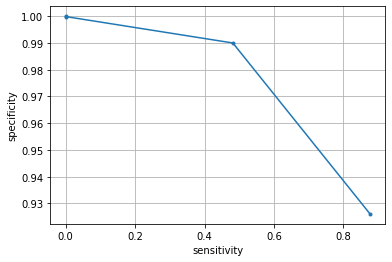

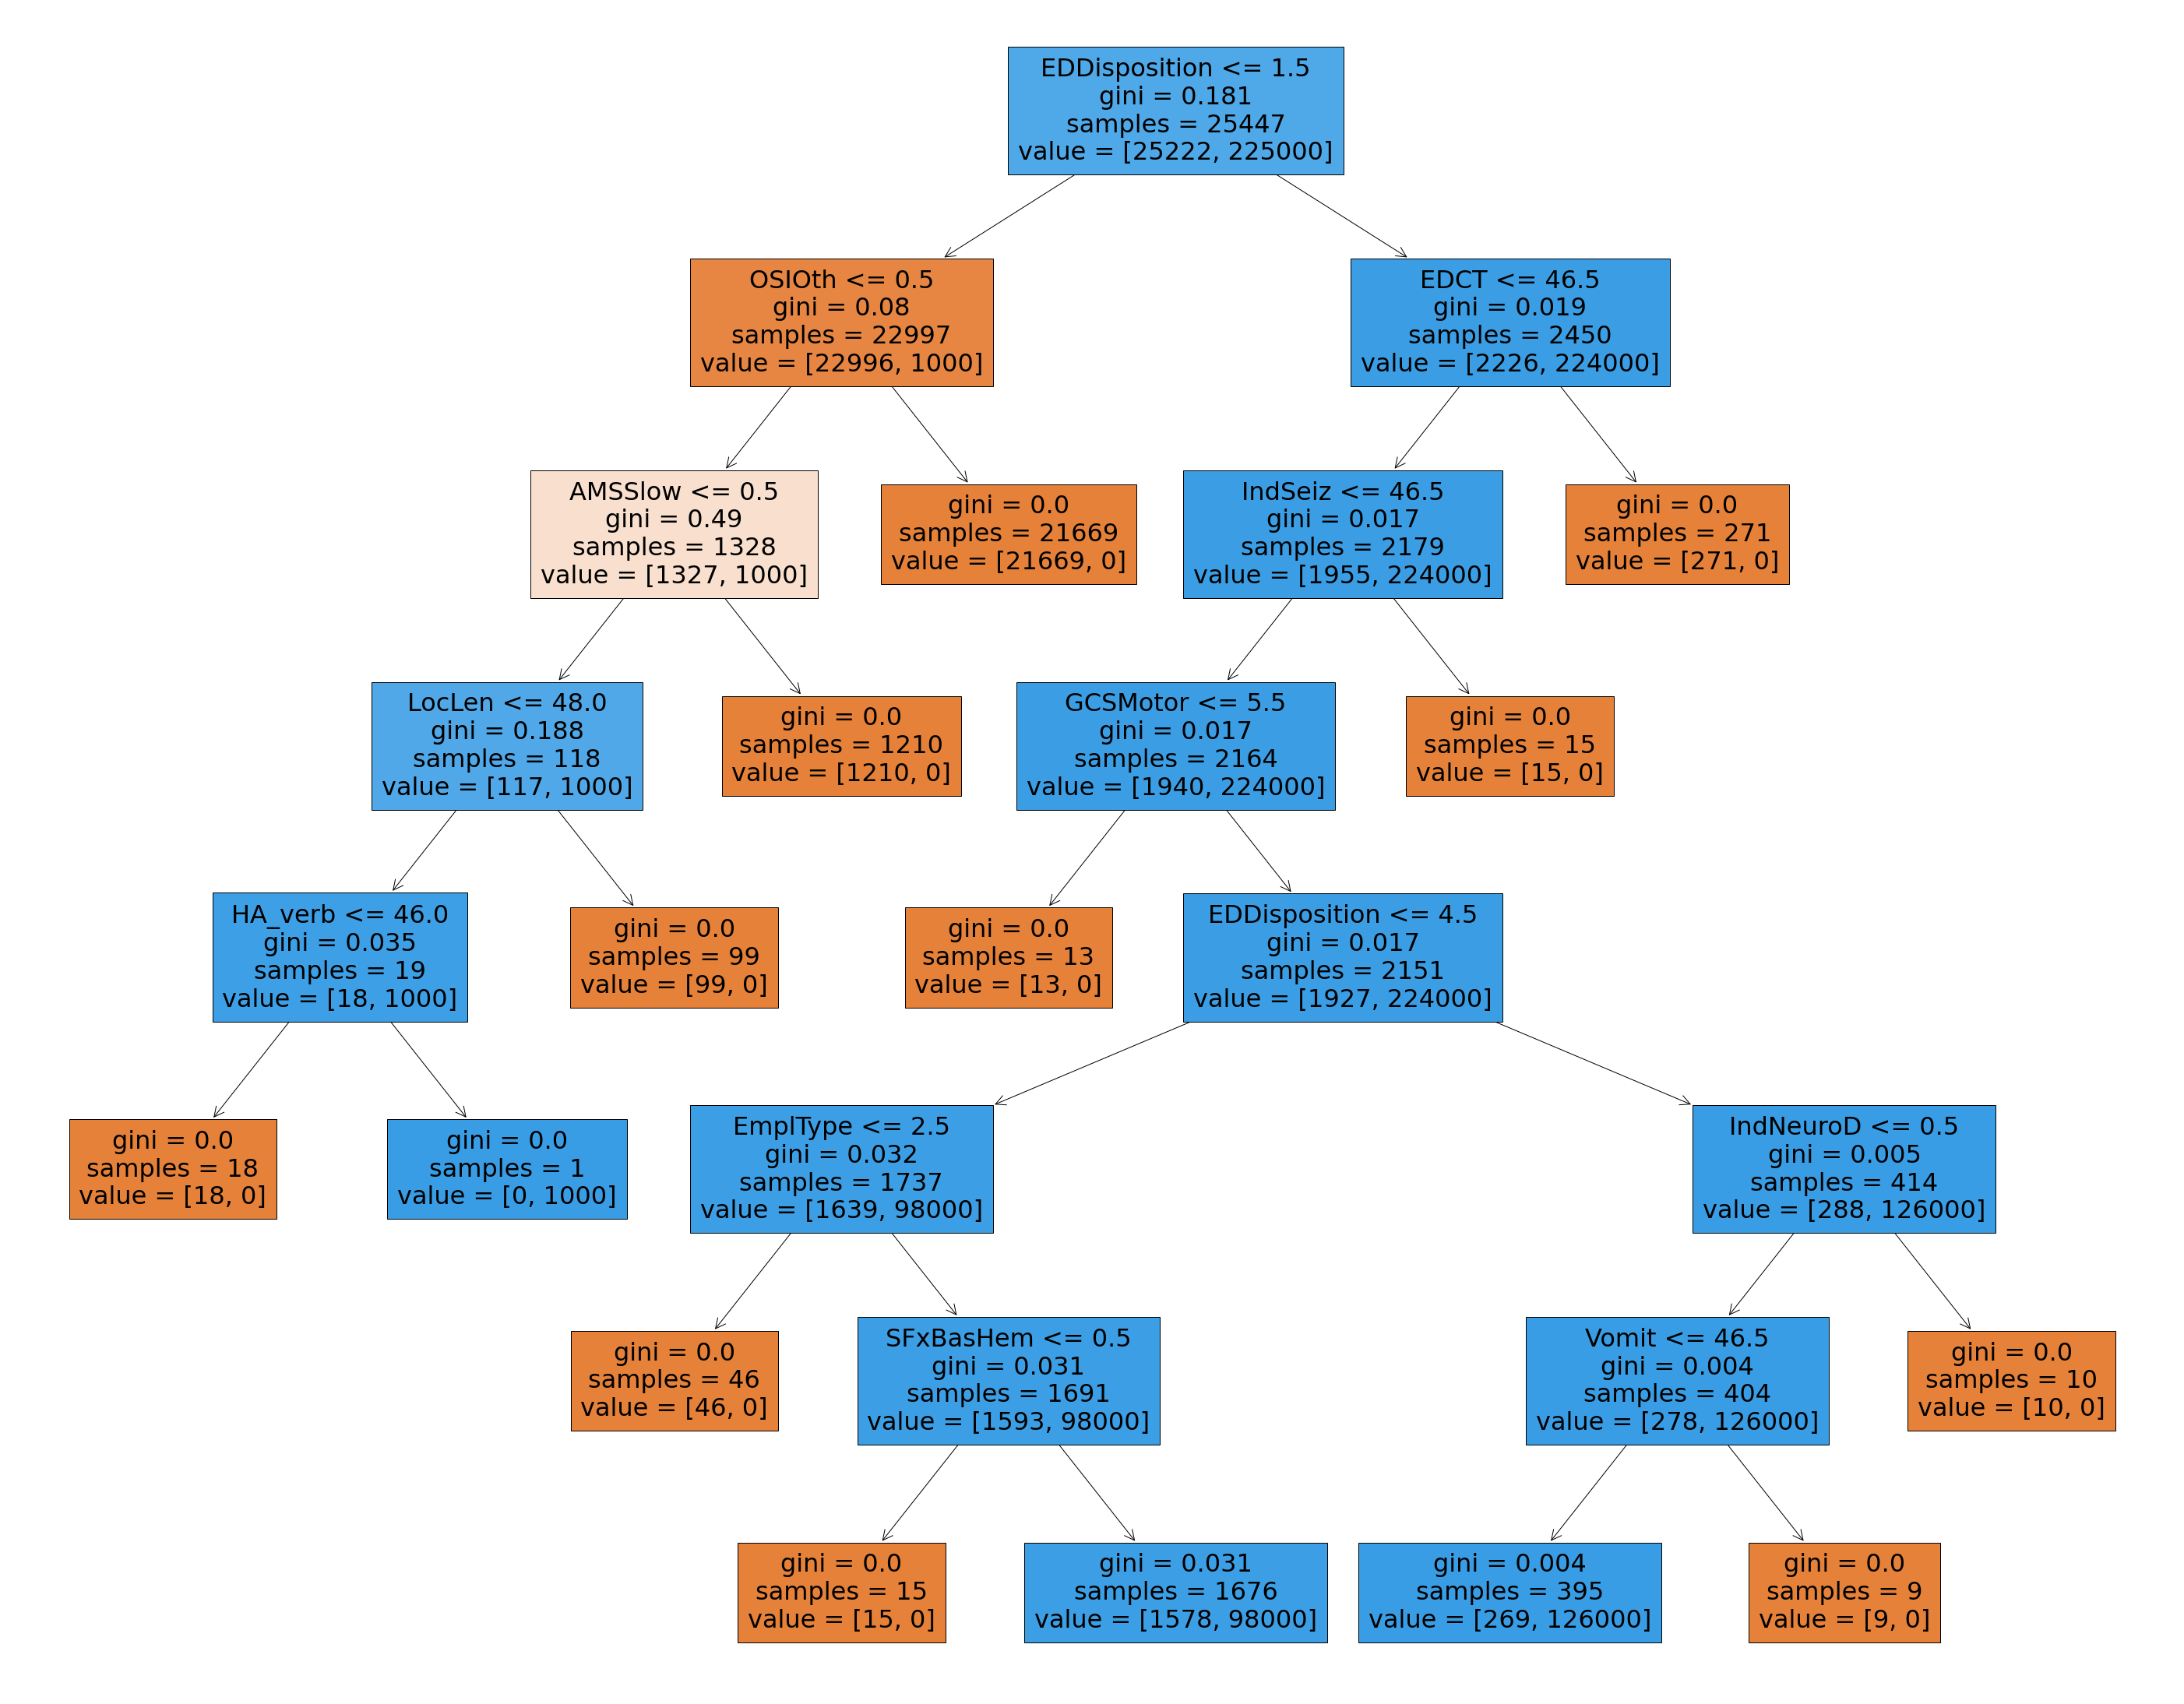

In [114]:
## Train a decision tree with depth = 7
dt = DecisionTreeClassifier(max_depth=7, class_weight={0: 1, 1: 1e3})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=X_train.columns, filled=True)
plt.show()

training bayesian_rule_list...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 31.10it/s]


Trained RuleListClassifier for detecting IwI
IF EDDisposition <= 1.5 THEN probability of IwI: 0.0% (0.0%-0.0%)
ELSE IF IndAMS > 46.5 THEN probability of IwI: 0.4% (0.0%-1.4%)
ELSE IF AMSRepeat <= 46.5 and SFxPalp <= 0.5 THEN probability of IwI: 13.3% (11.0%-15.7%)
ELSE IF SFxPalp <= 0.5 THEN probability of IwI: 5.7% (4.4%-7.0%)
ELSE probability of IwI: 28.4% (22.0%-35.3%)



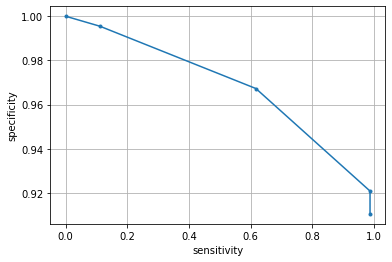

In [116]:
np.random.seed(13)
feature_names = X_train.columns
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=2, max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 295.24it/s]


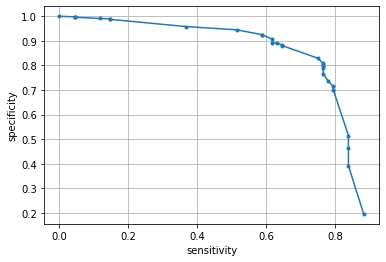

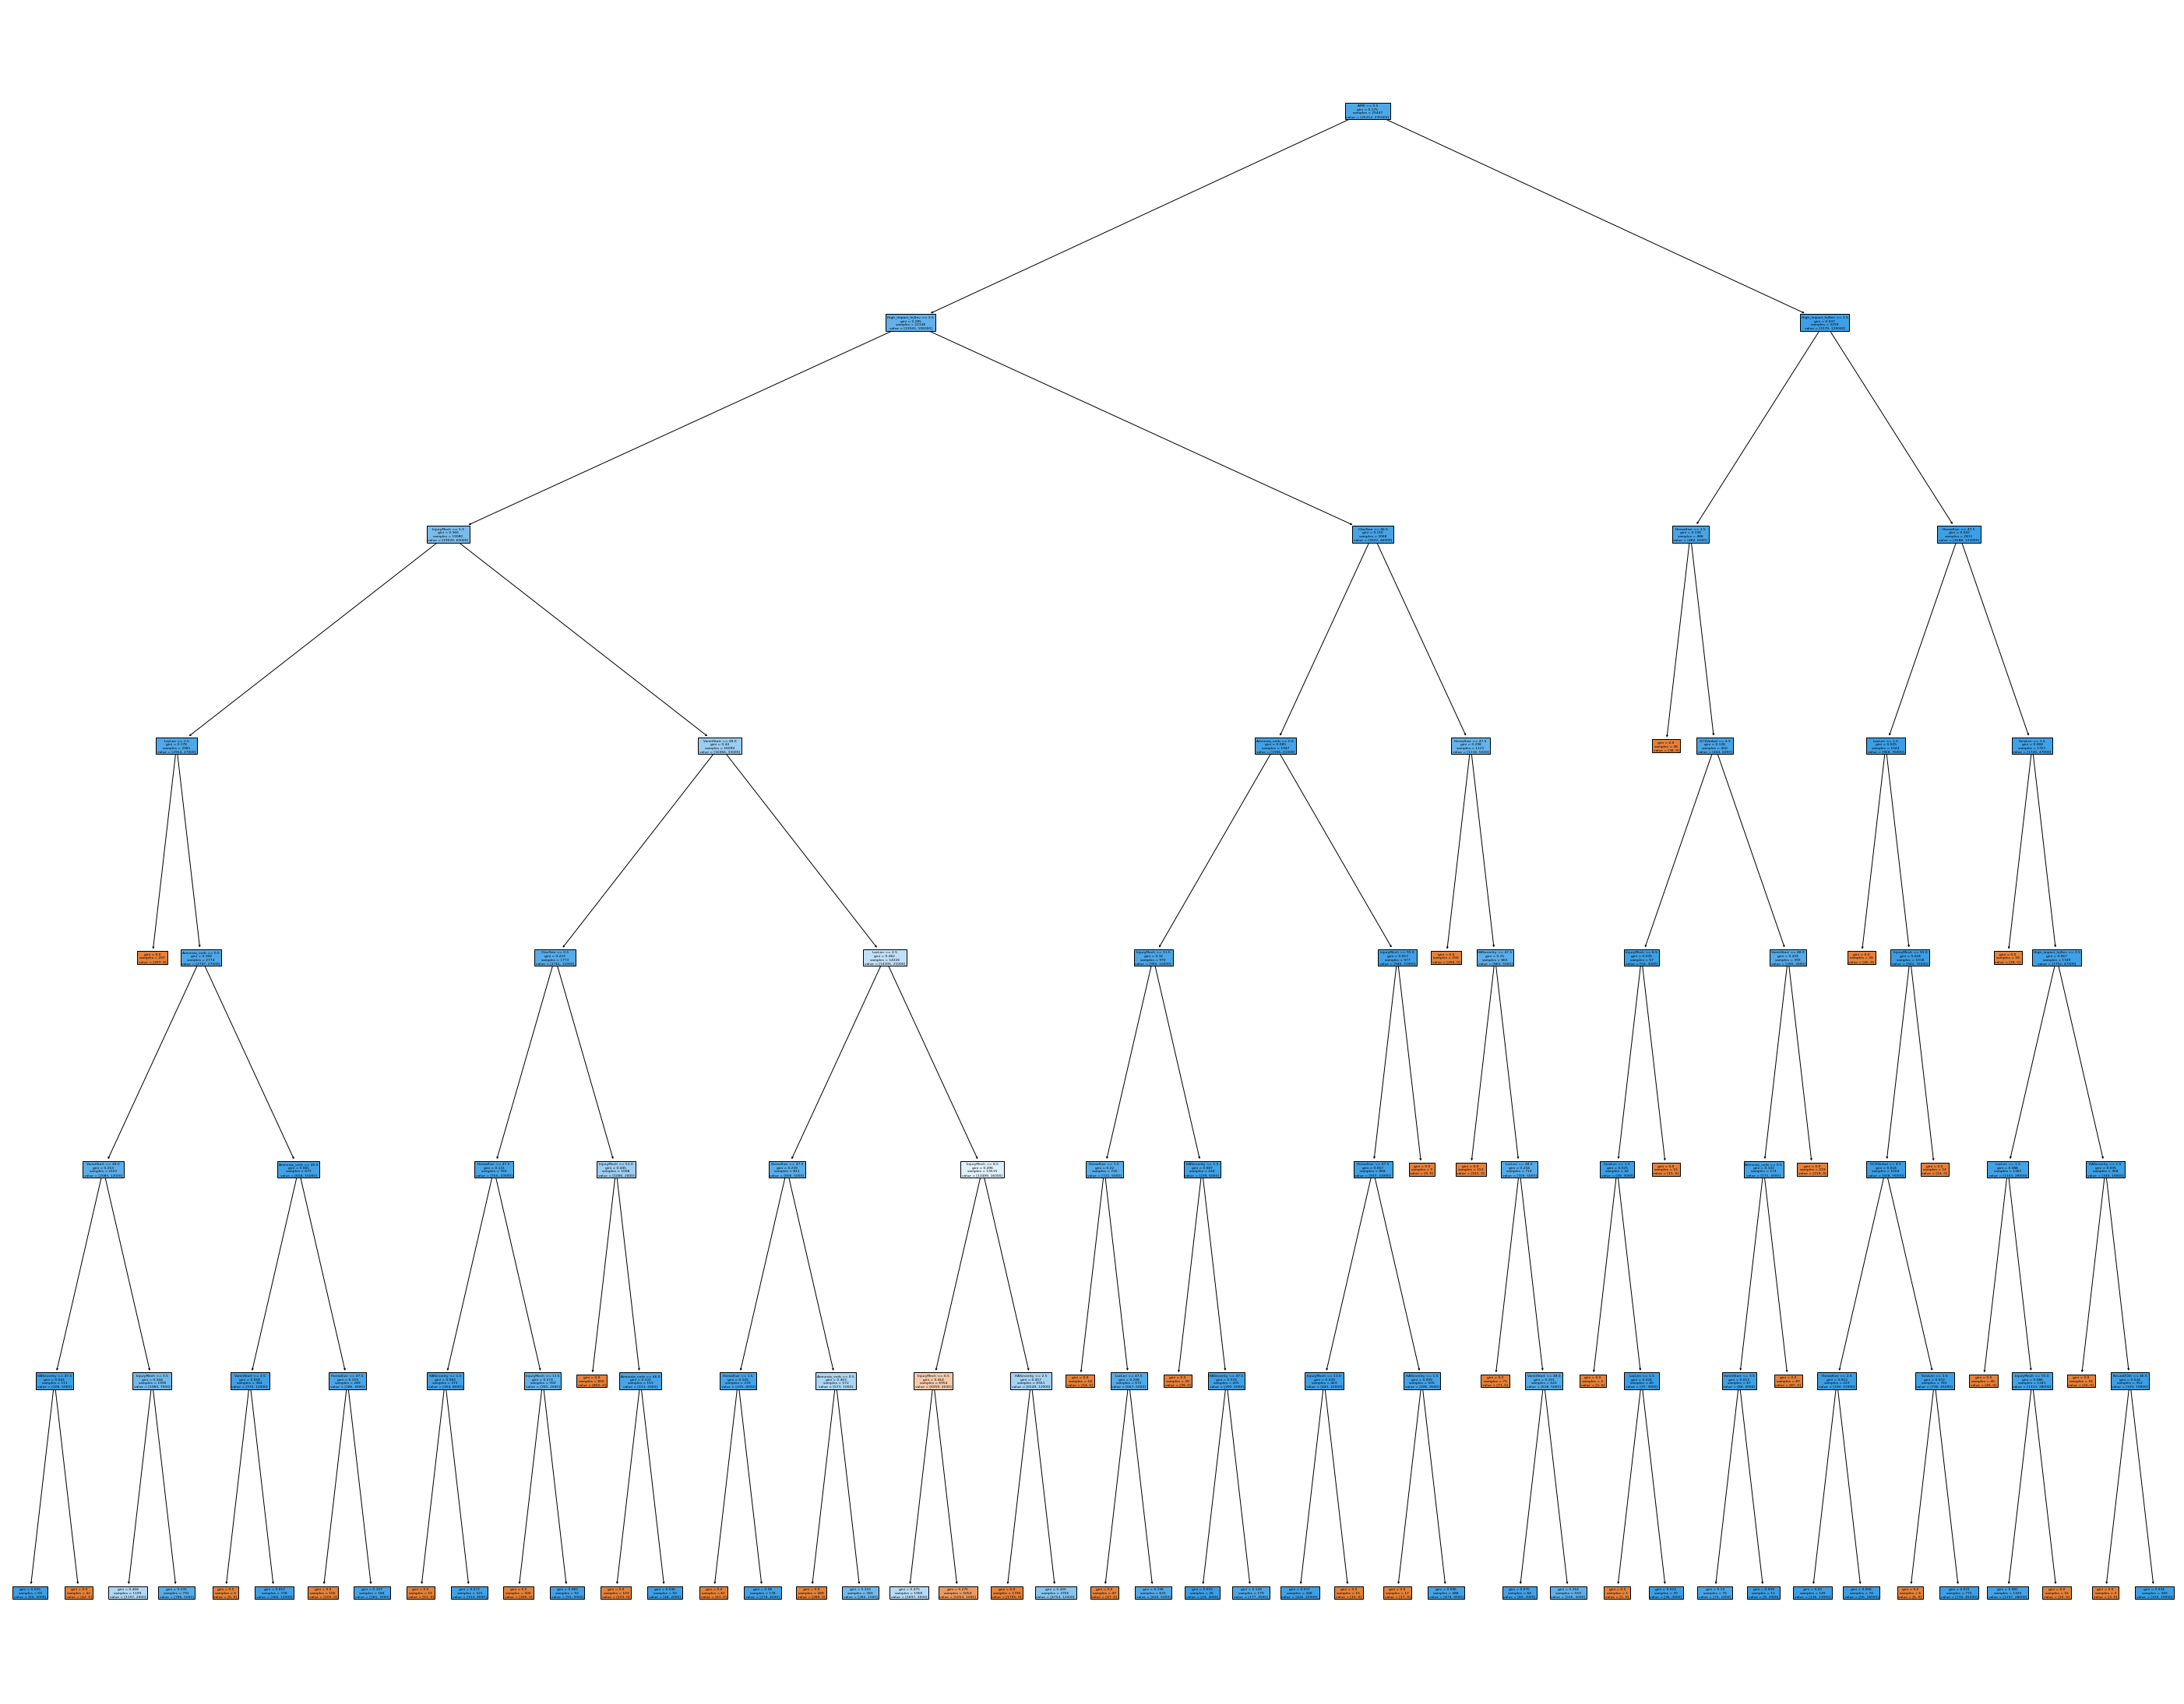

In [14]:
## Feature selection 
## According to the original paper, they analyzed children under 2 years old and above 2 years old separately
## We will fisrt build model on the whold training data set
## and then build model separately.
predictors = ["AMS","Amnesia_verb","ClavTem","GCSVerbal","HASeverity","HemaSize","High_impact_InjSev",
              "InjuryMech","LocLen", "NeuroDOth","SeizLen","VomitStart"]
X_train = train[predictors]
X_tune = tune[predictors]
dt_select = DecisionTreeClassifier(max_depth=7, class_weight={0: 1, 1: 1e3})
dt_select.fit(X_train, y_train)
stats, threshes = predict_and_save(dt_select, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt_select, feature_names=X_train.columns, filled=True)
plt.savefig("dt_select.png")

In [21]:
import sklearn.tree as sktree
r = sktree.export_text(dt_select, feature_names=predictors)
print(r)

|--- AMS <= 0.50
|   |--- High_impact_InjSev <= 2.50
|   |   |--- InjuryMech <= 5.50
|   |   |   |--- LocLen <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- LocLen >  2.50
|   |   |   |   |--- Amnesia_verb <= 0.50
|   |   |   |   |   |--- VomitStart <= 48.00
|   |   |   |   |   |   |--- HASeverity <= 47.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- HASeverity >  47.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- VomitStart >  48.00
|   |   |   |   |   |   |--- InjuryMech <= 3.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- InjuryMech >  3.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Amnesia_verb >  0.50
|   |   |   |   |   |--- Amnesia_verb <= 46.00
|   |   |   |   |   |   |--- VomitStart <= 2.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- VomitStart >  2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Amnesia_verb >  46.00
|   |   |  

In [70]:
train_young = train[train.AgeTwoPlus == 1].drop(columns = "AgeTwoPlus")
tune_young = tune[tune.AgeTwoPlus == 1].drop(columns = "AgeTwoPlus")
test_young = test[test.AgeTwoPlus == 1].drop(columns = "AgeTwoPlus")
X_train_young = train_young.drop(columns = outcomes)
X_tune_young = tune_young.drop(columns = outcomes)
X_test_young = test_young.drop(columns = outcomes)
y_train_young = train_young.PosIntFinal
y_test_young = test_young.PosIntFinal

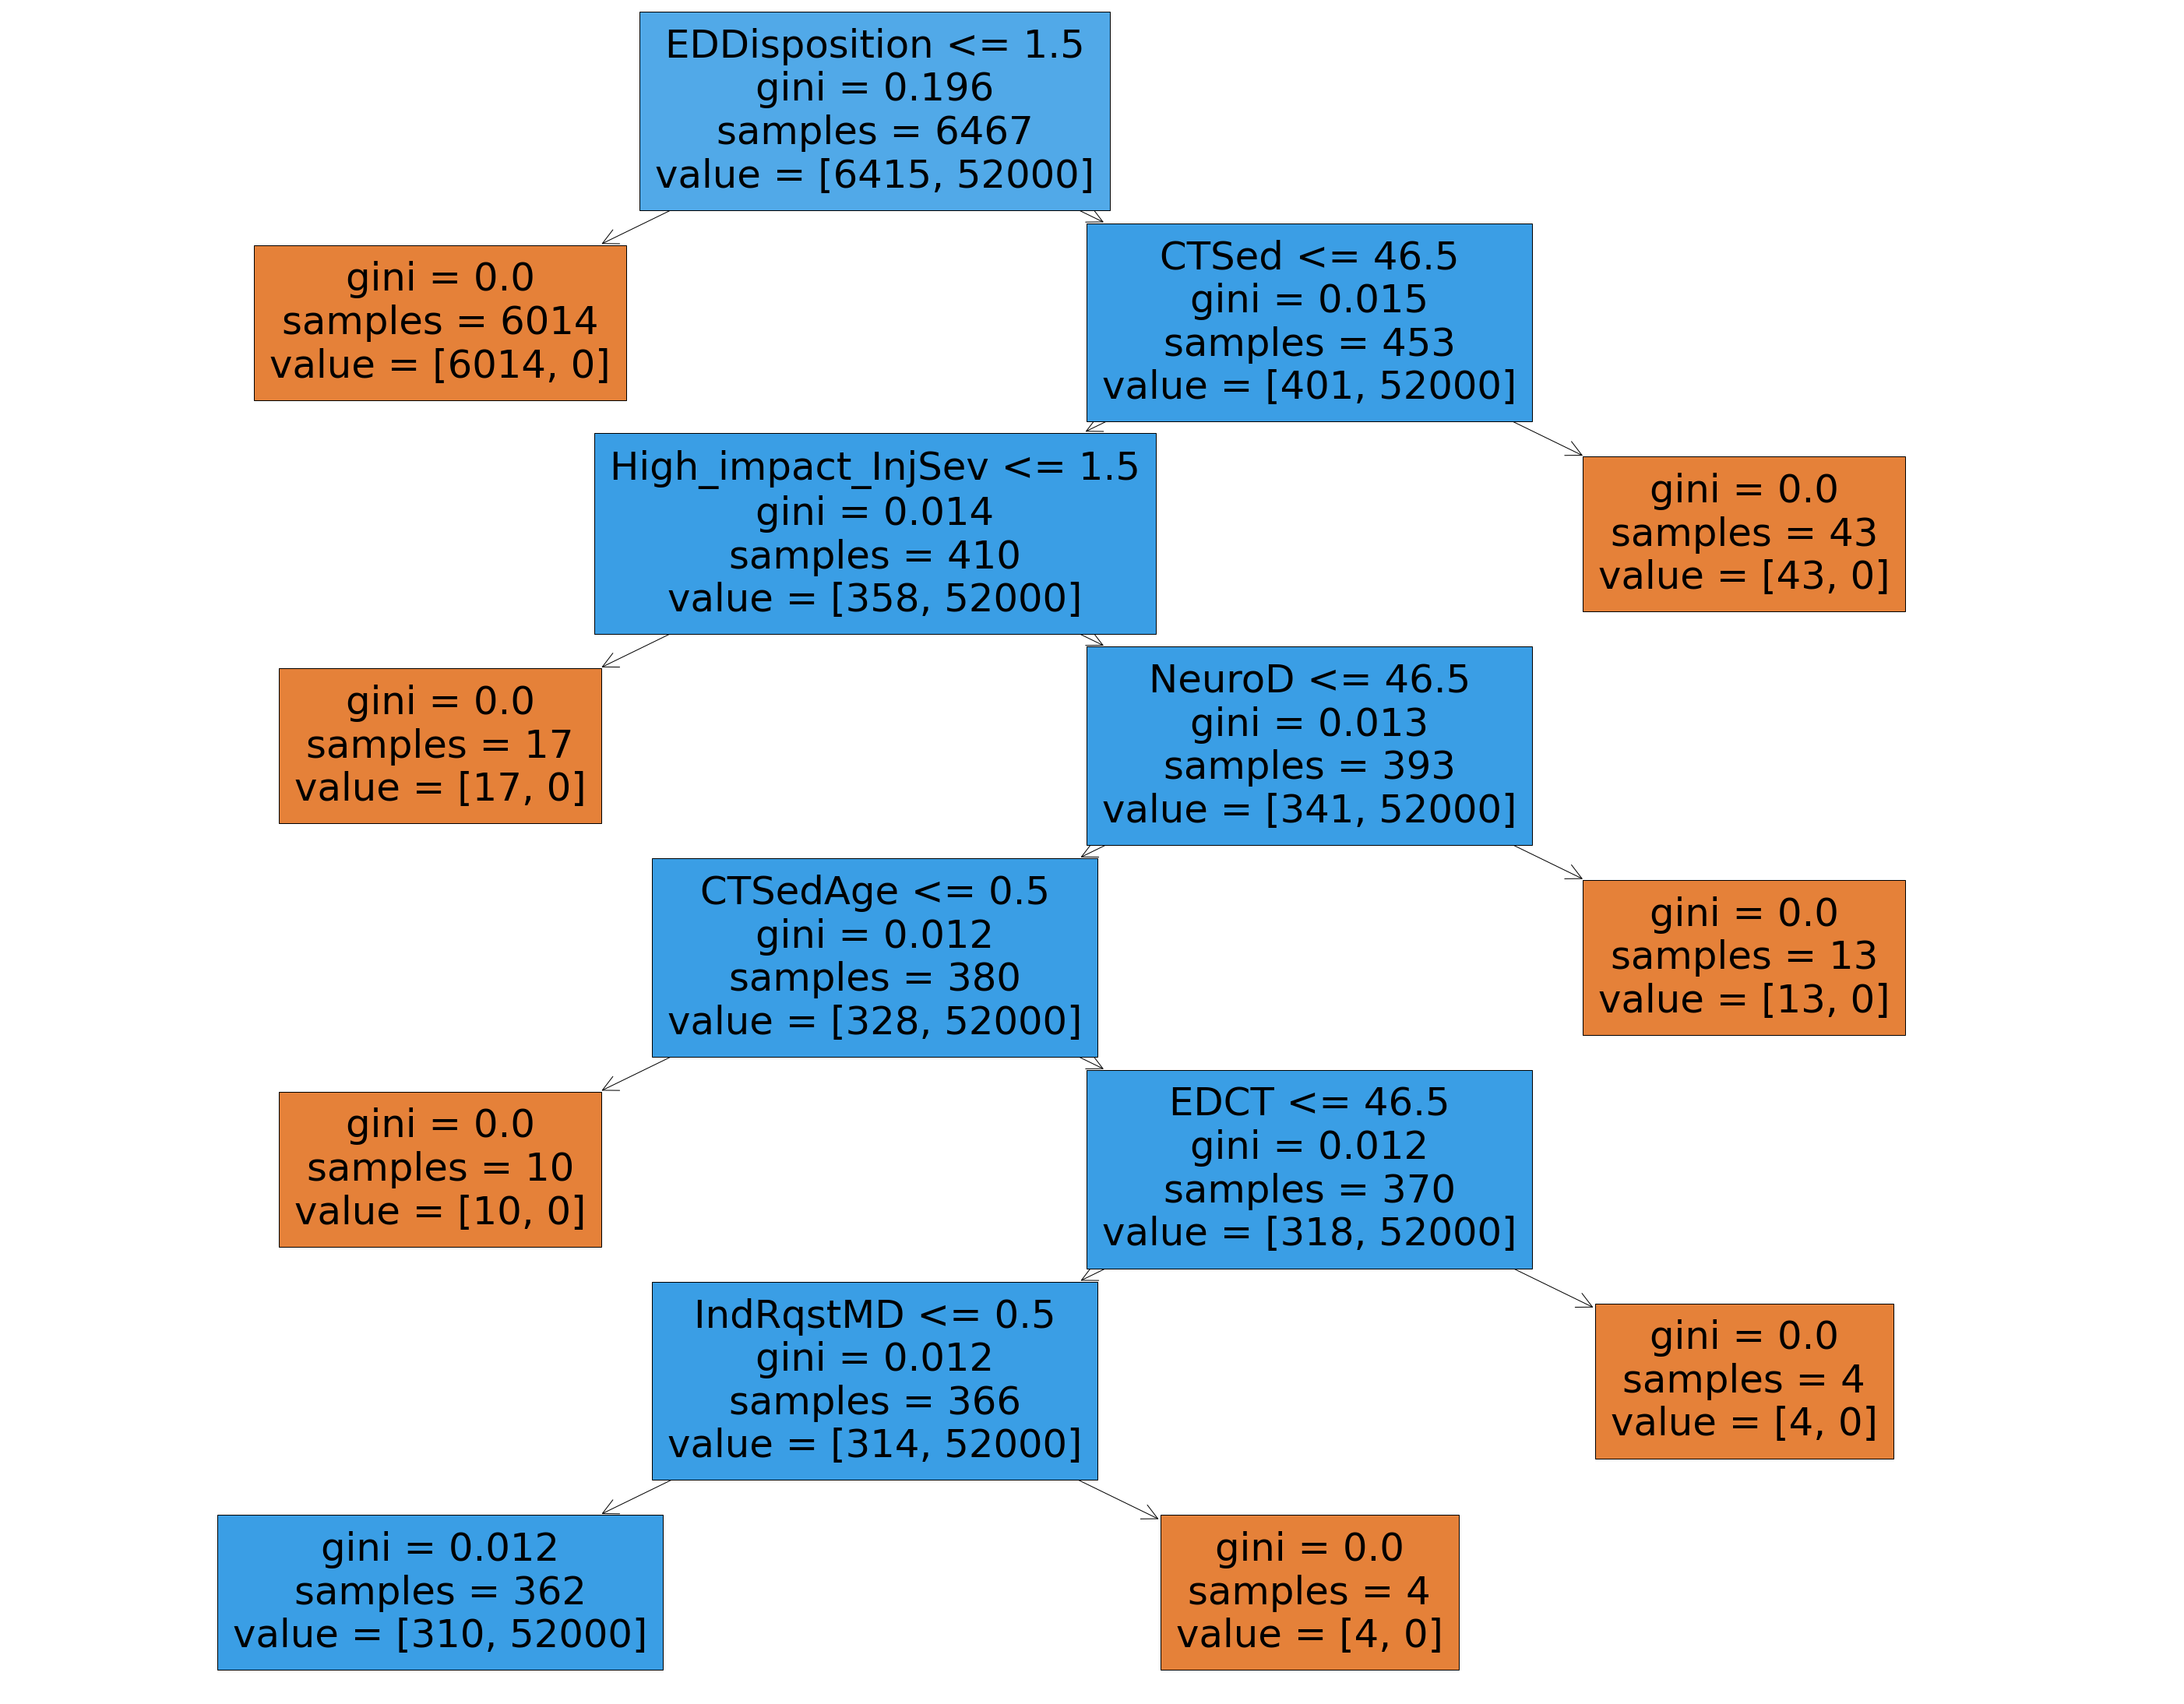

In [63]:
## Train a decision tree with depth = 7
dt_young = DecisionTreeClassifier(max_depth=7, class_weight={0: 1, 1: 1e3})
dt_young.fit(X_train_young, y_train_young)
# stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
# plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt_young, feature_names=X_train_young.columns, filled=True)
plt.show()

In [71]:
predict_results_young = dt_young.predict(X_test_young)
print(predict_results_young)
scores_young = dt_young.score(X_test_young, y_test_young)
scores_young

[0 0 0 ... 0 0 0]


0.9521780303030303

In [54]:
train_old = train[train.AgeTwoPlus == 2].drop(columns = "AgeTwoPlus")
tune_old = tune[tune.AgeTwoPlus == 2].drop(columns = "AgeTwoPlus")
test_old = test[test.AgeTwoPlus == 2].drop(columns = "AgeTwoPlus")
X_train_old = train_old.drop(columns = outcomes)
X_tune_old = tune_old.drop(columns = outcomes)
y_train_old = train_old.PosIntFinal
X_test_old = test_old.drop(columns = outcomes)
y_test_old = test_old.PosIntFinal

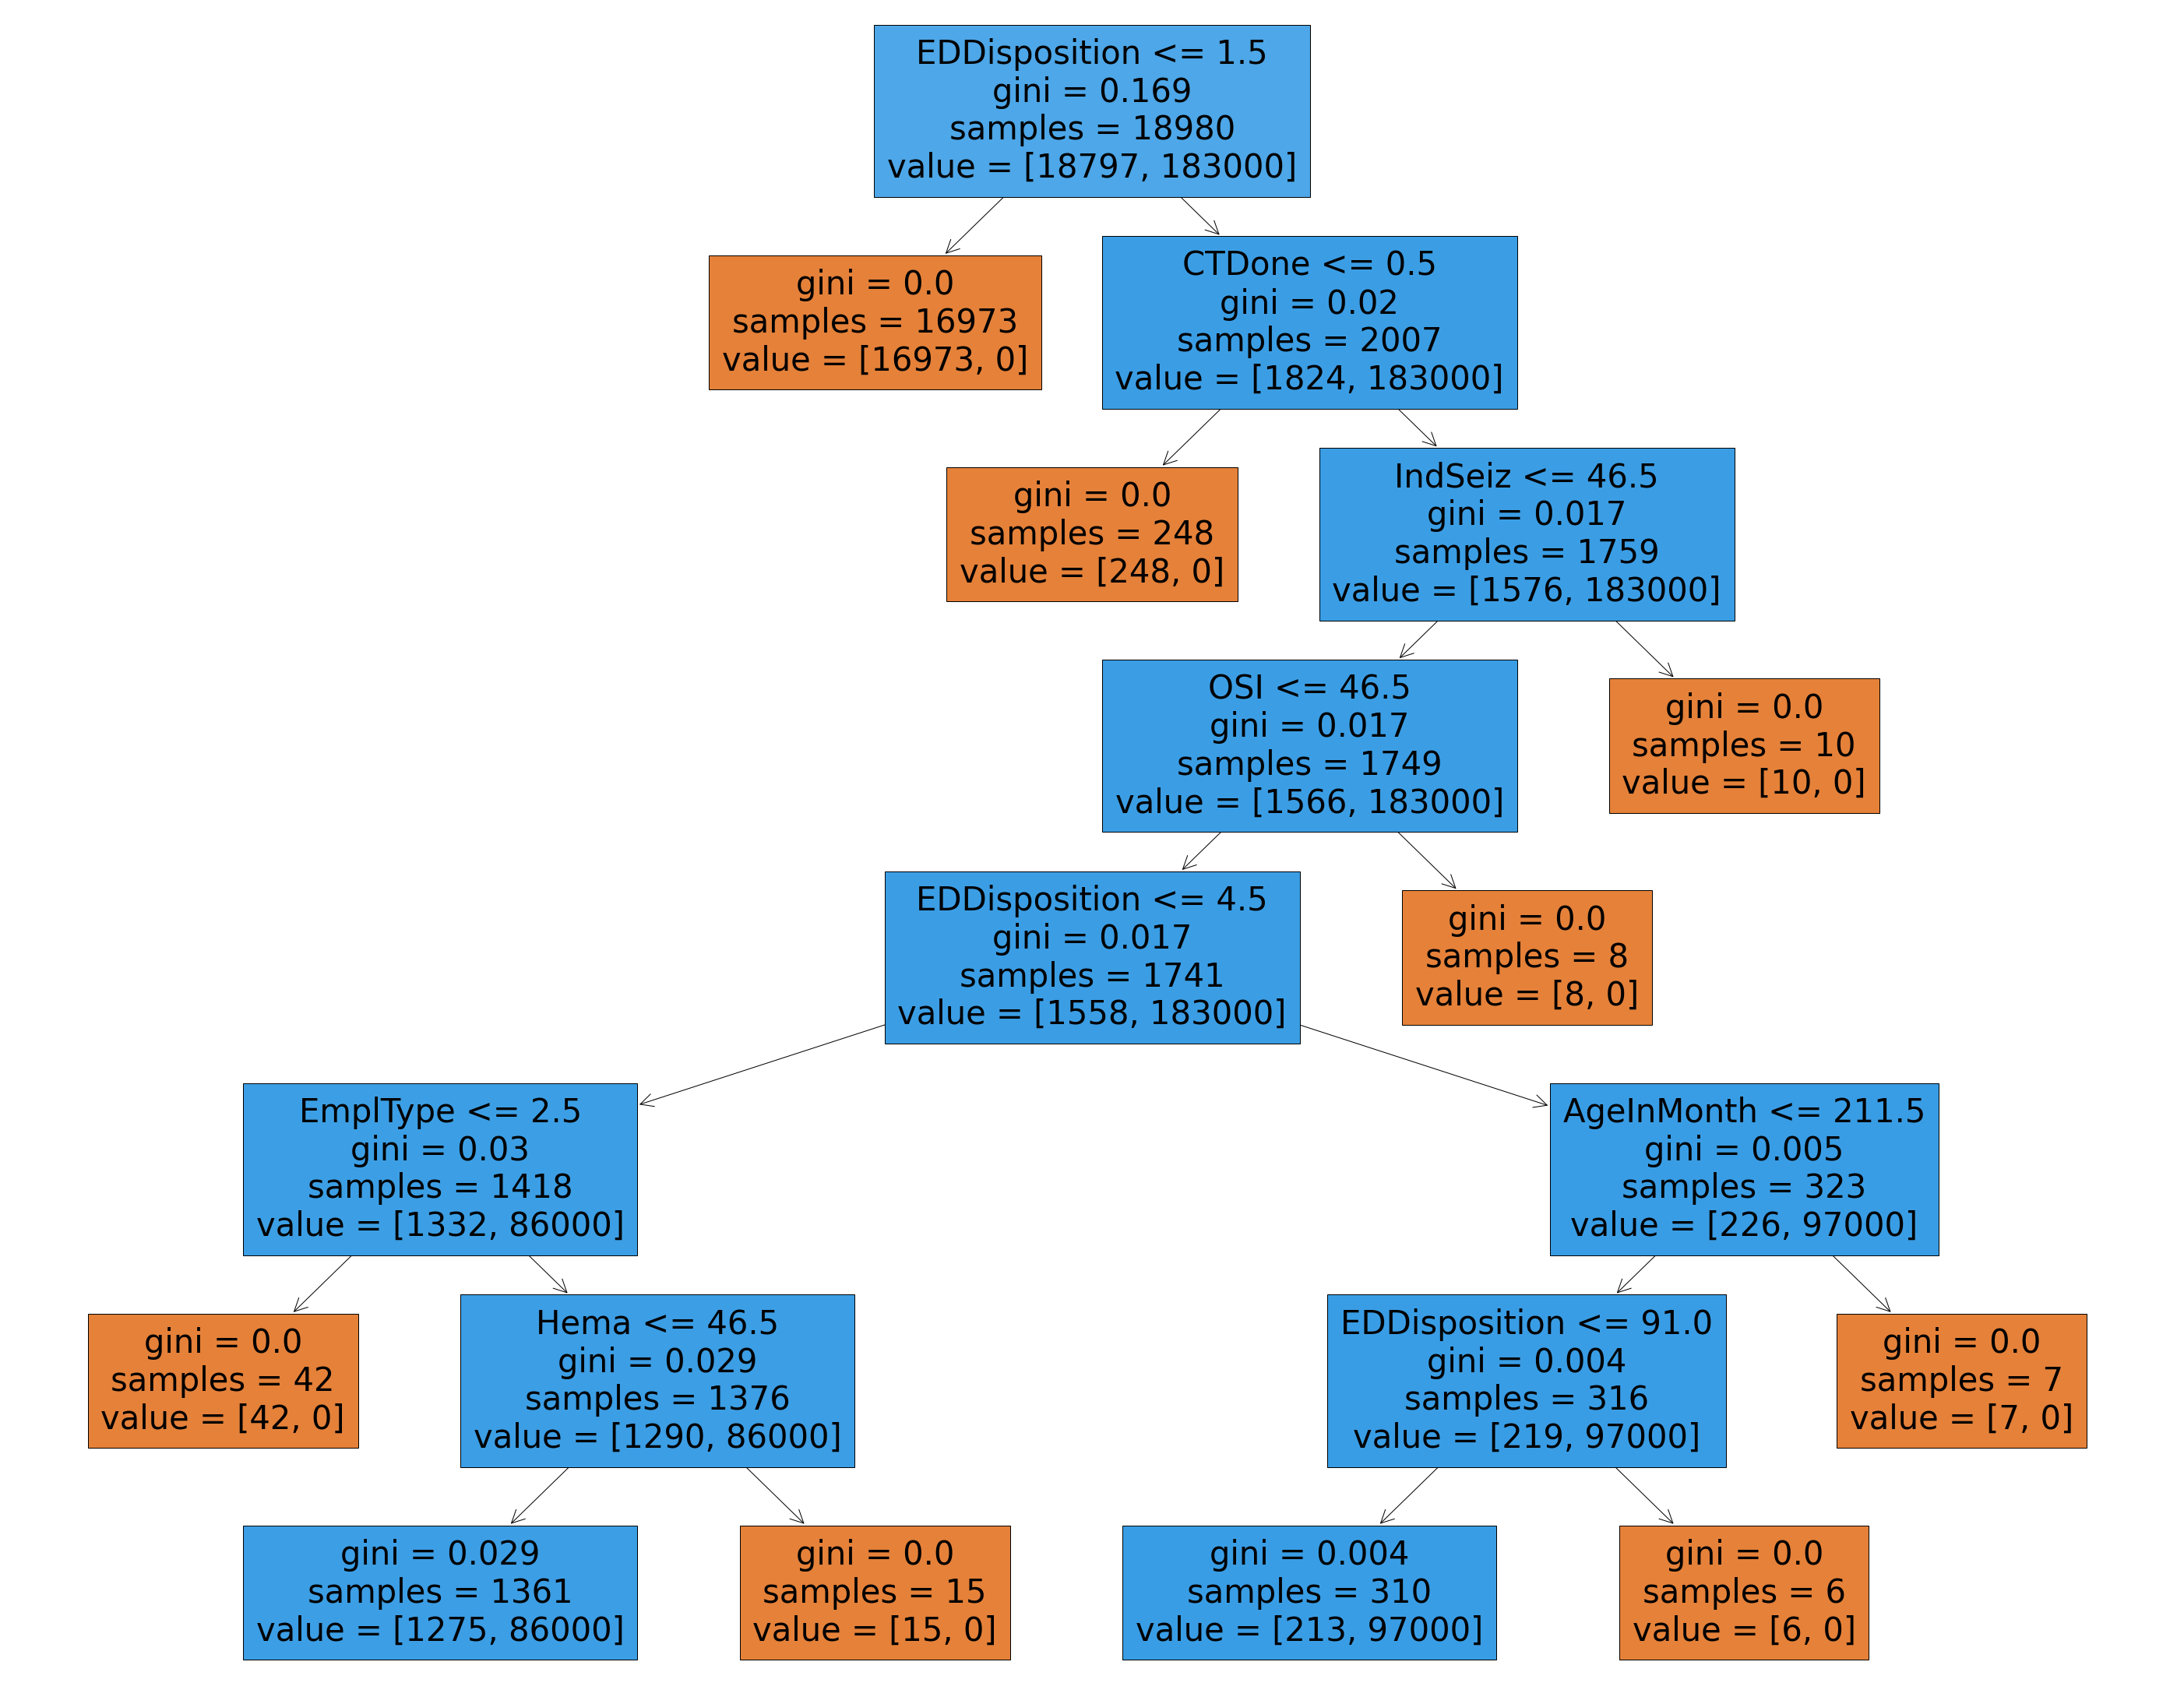

In [52]:
## Train a decision tree with depth = 7
dt_old = DecisionTreeClassifier(max_depth=7, class_weight={0: 1, 1: 1e3})
dt_old.fit(X_train_old, y_train_old)
# stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
# plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt_old, feature_names=X_train_old.columns, filled=True)
plt.show()

In [57]:
predict_results_old = dt_old.predict(X_test_old)
print(predict_results_old)
scores = dt_old.score(X_test_old, y_test_old)
scores

[1 0 1 ... 0 0 0]


0.9188510437921833